<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/Computer_Vision/Federated_Learning_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FEDERATED LEARNING WITH TENSORFLOW FEDERATED**

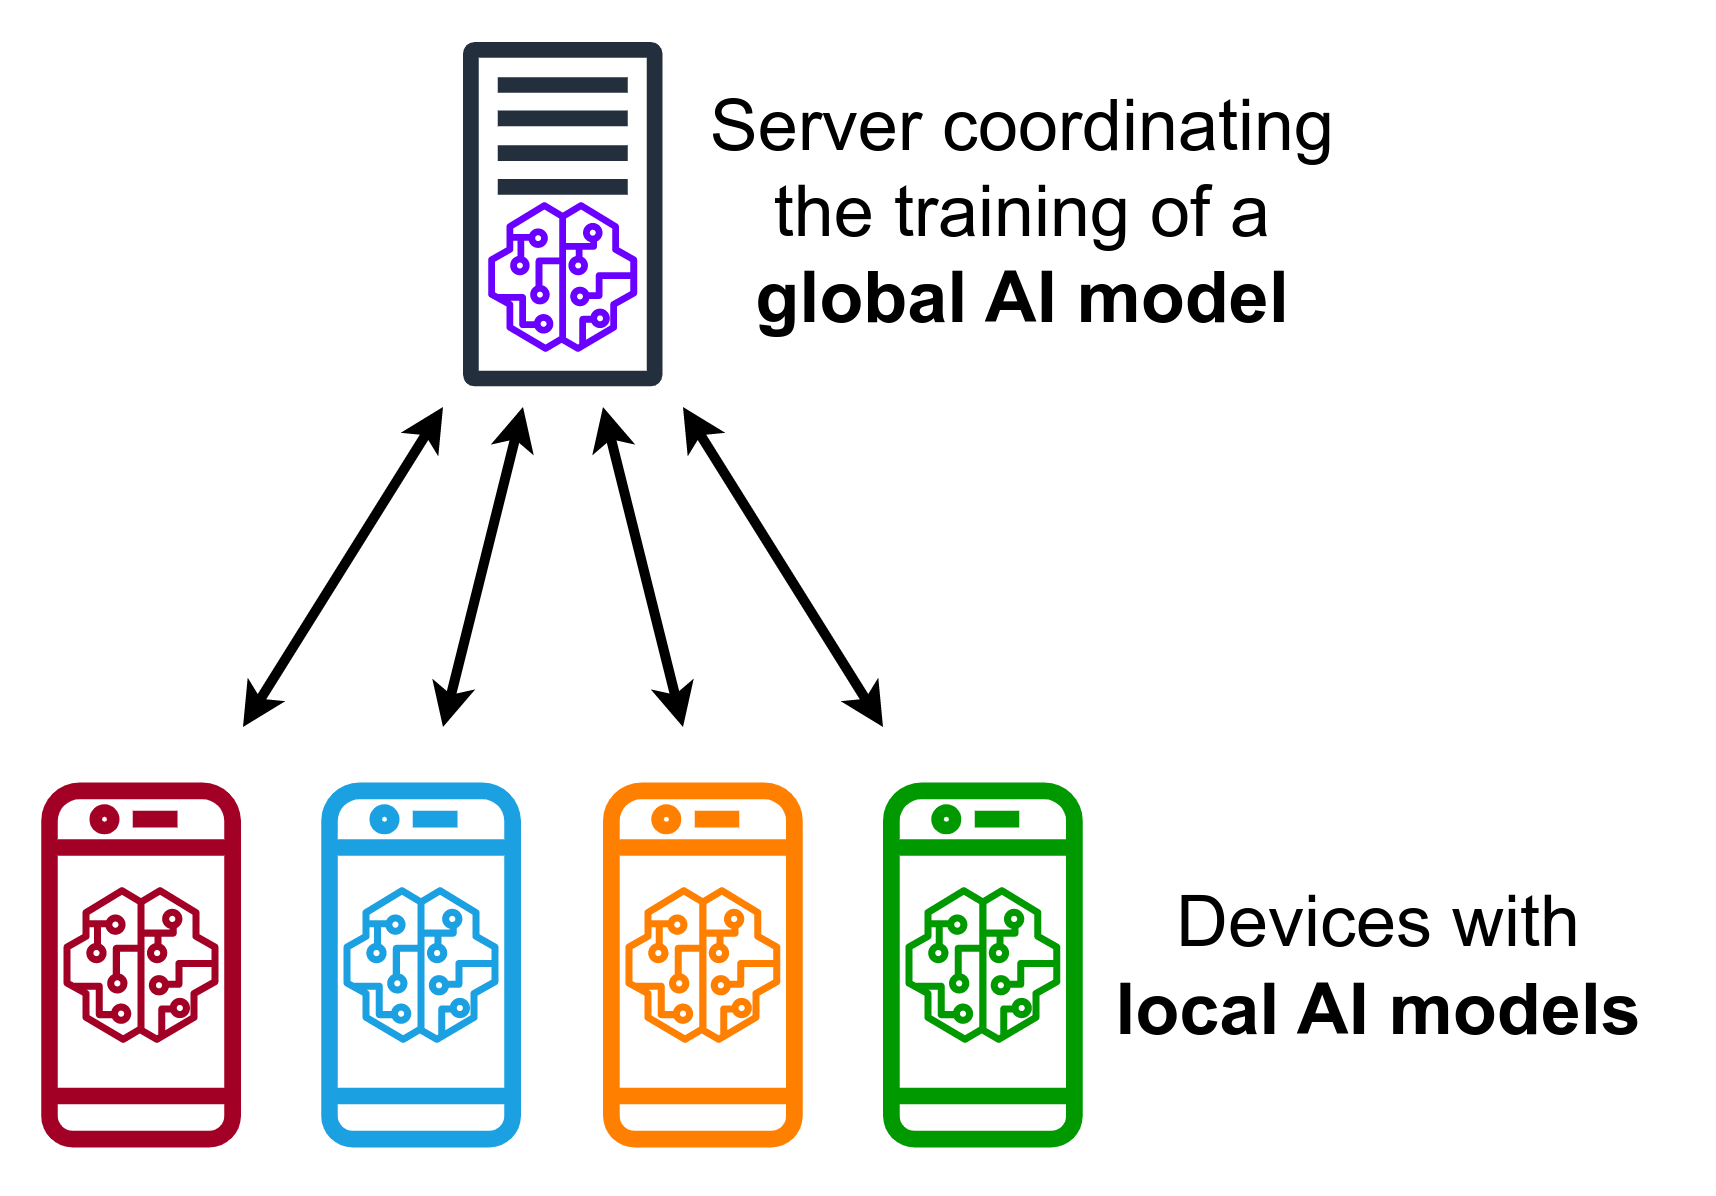

Use Cases of Federated Learning

*   **Healthcare:** Training models on sensitive patient data without compromising privacy.
*    **Finance:** Developing fraud detection systems using decentralized transaction data.
*  **Mobile Applications:** Improving predictive text models on smartphones without sending user typing data to servers.

## **I-LOAD OF LIBRAIRIES**

**library** is a collection of pre-written code modules that provide reusable functions, classes, and tools to simplify and accelerate software development for specific tasks or domains.


In [ ]:
#install the requirements librairies

!pip install tensorflow
!pip install tensorflow_federated


In [ ]:
#Import the requirements libraries for our task
#------------------------------------------------
import tensorflow as tf #
import tensorflow_federated as tff #
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm.auto import tqdm


## **1-Building a Simple Federated Learning Model**

## 1-1- Loading and Preprocessing the Data

**The MNIST (Modified National Institute of Standards and Technology)** dataset is a classic machine learning and computer vision database consisting of 70,000 handwritten digit images (0-9) in black and white, sized 28x28 pixels. Each image is labeled with its corresponding digit, making it a perfect dataset for learning image classification algorithms and testing character recognition models.

In [ ]:
#loads the MNIST dataset from TensorFlow,
mnist = tf.keras.datasets.mnist
#splitting it into training and testing sets of images and their corresponding digit labels.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

**Data preprocessing** is a critical initial step in machine learning that transforms raw data into a format suitable for model training.

For image datasets like MNIST, preprocessing typically involves several key techniques:



*   **normalization**: which scales pixel values to a consistent range (usually [0-1]) to improve learning efficiency and model convergence;

*   **dimensionality adjustment**, where images are reshaped to ensure compatibility with neural network architectures, often adding a channel dimension for grayscale or color images;

*    **label encoding**, converting categorical labels into one-hot vectors to enable multi-class classification.

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


## 1-2-Simulating Clients and Creating TensorFlow Datasets

**Simulating Clients** refers to creating multiple virtual client environments that mimic different data distributions, network conditions, and computational capabilities to test and validate how a machine learning model performs across diverse scenarios without requiring actual physical devices.

In [ ]:
#simulates the federated environment by splitting the dataset into different clients:
NUM_CLIENTS = 10
client_data = []
data_per_client = len(x_train) // NUM_CLIENTS
for i in range(NUM_CLIENTS):
    start = i * data_per_client
    end = (i + 1) * data_per_client
    client_data.append((x_train[start:end], y_train[start:end]))

## 1-3-Training the Federated Learning Model

**The Federated Averaging algorithm** is used to perform federated learning for multiple rounds:

In [ ]:
# Create a custom callback to display tqdm progress bar during model training
class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, leave=True):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.leave = leave
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.epochs, desc="Training epochs", leave=self.leave)

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()


In [ ]:
# Define the model creation function
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
# Create the global model
global_model = create_model()

# Parameters for federated training
NUM_ROUNDS = 5
LOCAL_EPOCHS = 2
BATCH_SIZE = 64

# History to track performance
history = {
    'global_accuracy': [],
    'global_loss': [],
    'global_auc': []
}

In [ ]:
# Federated training
for round_num in tqdm(range(NUM_ROUNDS), desc="Federated rounds"):

    # List to store weights from local models
    local_weights = []

    # Train local models for each client
    for client_id in tqdm(range(NUM_CLIENTS), desc="Training clients", leave=False):
        x_local, y_local = client_data[client_id]

        # Create local model and initialize with global model weights
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())

        # Train the local model on client data
        local_model.fit(
            x_local,
            y_local,
            epochs=LOCAL_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[TqdmProgressCallback(LOCAL_EPOCHS, leave=False)]
        )

        # Add the local model weights to the list
        local_weights.append(local_model.get_weights())

    # Aggregate weights (FedAvg algorithm)
    averaged_weights = []
    for layer_weights in zip(*local_weights):
        averaged_weights.append(np.mean(np.array(layer_weights), axis=0))

    # Update global model with averaged weights
    global_model.set_weights(averaged_weights)

    # Evaluate the global model
    test_loss, test_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
    print(f"  Global model accuracy after round {round_num + 1}: {test_accuracy:.4f}")

    # Calculate AUC for multi-class classification (one-vs-rest)
    y_pred_proba = global_model.predict(x_test, verbose=0)
    y_test_bin = label_binarize(y_test, classes=range(10))
CIDP CSO Social Network Hackathon
    # Calculate AUC for each class with tqdm
    auc_scores = []
    for i in tqdm(range(10), desc="Calculating AUC", leave=False):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        auc_scores.append(auc(fpr, tpr))

    # Average AUC across all classes
    mean_auc = np.mean(auc_scores)
    print(f"  Global model mean AUC after round {round_num + 1}: {mean_auc:.4f}")

    # Save metricsCIDP CSO Social Network Hackathon
    history['global_accuracy'].append(test_accuracy)
    history['global_loss'].append(test_loss)
    history['global_auc'].append(mean_auc)

In [ ]:
# Plot accuracy, loss, and AUC over rounds
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_ROUNDS + 1), history['global_accuracy'])
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Global Model Accuracy')

plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_ROUNDS + 1), history['global_loss'])
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Global Model Loss')

plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_ROUNDS + 1), history['global_auc'])
plt.xlabel('Round')CIDP CSO Social Network Hackathon
plt.ylabel('AUC')
plt.title('Global Model AUC')

plt.tight_layout()
plt.savefig('federated_learning_performance.png')
plt.show()


In [ ]:

# Plot ROC curves for the final model
plt.figure(figsize=(10, 8))
y_pred_proba = global_model.predict(x_test, verbose=0)
y_test_bin = label_binarize(y_test, classes=range(10))

# Plot ROC for each digit class
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Digit Classes')
plt.legend(loc="lower right")
plt.savefig('federated_learning_roc_curves.png')
plt.show()




## 1-4-Evaluating the Model

After the federated learning rounds, the global model will be evaluated on the centralized test dataset:

In [ ]:

# Make predictions with the final model
# Select some examples for visualization
num_examples = 5
sample_indices = np.random.choice(len(x_test), num_examples, replace=False)
samples = x_test[sample_indices]
true_labels = y_test[sample_indices]

# Make predictions
predictions = global_model.predict(samples)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:

# Display examples with predictions
plt.figure(figsize=(15, 3))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('federated_learning_predictions.png')
plt.show()


## 1-5-Model save

In [ ]:

# Save the final model
global_model.save('federated_learning_mnist_model.h5')
print("Trained model saved successfully!")

## 1-6-Load the save model

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('federated_learning_mnist_model.h5')
print("Model loaded successfully!")
